# Experimenting with Adversarial Examples

The purpose of this notebook is to experiment with image classifiers performance on adversarial examples.

More specifically, the goal is to investigate how activation strengths compare between test examples and adversarially perturbed test examples.

While attempting to set up this notebook, I recalled/learned for the first time that there is an entire field called **attributions** which attempts to answer the question "What caused this neural net to give this output?"
(As a reminder, see [Building Blocks of Interpretability](filter_zero_activations) for a discussion of how attribution and feature visualization are complementary techniques for interpreting neural nets.)

Different attribution techniques exist to answer different sharpenings of this question such as
1. Which pixel of an image most strongly impacted the classification result?
2. Which neurons in layer X most strongly impacted the classification result?
3. Many, many other permutations of similar questions.

The [Captum library](https://captum.ai) is an implementation of several types of attribution techniques for PyTorch.
See their [algorithm page](https://captum.ai/docs/algorithms) for a list of supported algorithms and a short description of how each one works.

Looking at activation strengths of neurons in specific layers when a net is applied to an adversarial example seems to be in the spirit of other, more complex, attribution methodologies.

However, I was not able to find any papers which made use of neuronal activations specifically when doing an attribution analysis.

Bear in mind that I did not look very closely as I mostly wanted to get my hands dirty instead of reading what other people have done.

I would not be surprised if comparing activations has conceptual weaknesses as an attribution strategy when compared to other approaches, which tend to rely on integration versus simply studying individual activations.

Regardless, for the sake of curiosity and testing conjectures made in our last meeting, it seemed fun and valuable to play around with.

## Method
I have implemented very basic plotting and statistical analysis for activation strenghts.
The `torchvision.models.feature_extraction` module is used to extract activations from models.

All adversarial examples are generated using fast gradient sign method (FGSM) applied to examples from ImageNet.
FGSM is easy to implement and quick to calculate, but it is only one of many possible methods of generating adversarial examples which have been studied.

I have only examined the activations of the AlexNet model, for a few test examples.
Other models and examples might give different results.

## Source Code
Source code for this notebook is in large part based on [Adversarial_Attacks.ipynb](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb#scrollTo=RU-Ng1nP0Y6p), written by Philip Lippe from the University of Amsterdam.

Set up common libraries.

Uncomment the line `pl.seed_everything(42)` to make the results deterministic.
As is, images will be pulled randomly from the data set.

In [ ]:
## Standard libraries
import os
import json
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.utils.data as data
import torch.nn.functional as F
# Torchvision
import torchvision
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

In [ ]:
# Uncomment the next line to turn make results deterministic
# pl.seed_everything(42)

Download data sets.

In [ ]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github url where a pre-processed ImageNet data set is located; this data set was prepared by Philip Lippe
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])
print("Done!")

Set up a ConvNet.
The AlexNet model is used by default here, but this can be changed to any of the models included in the Torchvision library, such as various ResNet implementations.

**Caution**: if you change the model used here, you might need to do some pre-processing to the data set to get it in the format which the model expects.
It might be easier to simply begin from the original ImageNet database and then check PyTorch documentation for guidance about the format required for the model.

In [ ]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
# Change 'alexnet' to any other model included in torchvision, taking into account the above caution
pretrained_model = torchvision.models.alexnet(pretrained=True)
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Create a data loader. 
The data loader will:
- Normalize the ImageNet data
- Handle loading the files
- Handle loading labels

In [ ]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join("../data", "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False, num_workers=2)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

Perform an initial validation on the model.
The dataset has been clipped for performance reasons.
Change the value of `max_validations` to 0 to use the full dataset.

First, define an `eval_model` function to perform validations.

In [ ]:

def eval_model(dataset_loader, max_validations = 1000, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    iterator = tqdm(dataset_loader, desc="Validating...")
    for imgs, labels in iterator:
        # Break out of loop if we have exceeded max_validations
        if max_validations != 0 and counter > max_validations:
            iterator.close()
            break
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    print(f"Validations performed: {counter}")
    return acc, top5

Now, validate the model we are examining.

In [ ]:
_ = eval_model(data_loader)

Function for showing an image/adversarial example and the correct/predicted labels.

In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None] # What effect does removing/changing this line have?
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        _, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        _, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)          # What shape is pred here?
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

Sample visualizations:

In [ ]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
print(f"len(exmp_batch): {len(exmp_batch)}")
for i in range(0,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Fast Gradient Sign Method (FGSM)


In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.2):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL (what is NLL here -- negative lost likelihood?)
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device)).detach()
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

Try using FGSM on example images.

Observe that for `epsilon = 0.02`, the adversarial example results in classifications spread across a similar class of objects: different dog breeds for dogs, different fish breeds for fish.

For `epsilon = 0.5` however, the results are in unrelated categories: bears are labeled as anything from a dog to a sock, cars are seen as jigsaw puzzles, peacocks, or chain link fences.

In the `epsilon = 0.5` case, the images are noticeably blurred, but are still clearly an element of a larger category such as bear, car, shark, and so on.

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(0,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

Evaluate the adversarial examples:

In [ ]:
_ = eval_model(data_loader, img_func=lambda x,y: fast_gradient_sign_method(pretrained_model,x,y, epsilon=0.02)[0])

# New content
Up to now, this material has largely been taken from Philip Lippe's tutorial notebook.
The question now is how to examine activations of neurons in adversarial examples.
Try it out:
Steps
1. Learn how to view model activations "neuron by neuron" as they occur using PyTorch.
2. Find a way to record activations in a way that is meaningful. 

In [ ]:
test_img, test_label = next(iter(data_loader))
test_img= test_img[1:2]
test_label = test_label[1:2]

In [ ]:
# What shape is output from a model?
with torch.no_grad():
    preds = pretrained_model(test_img)
    print(preds.shape) # preds has shape batch_size x # classes; so in this case, 1 x 1000

In [ ]:
# How to convert a model's output to the model's most confident classification
y = torch.argmax(preds[-1])
print(y.item())
adv = fast_gradient_sign_method(pretrained_model, test_img, test_label, 0.3)

In [ ]:
# Apply the model to an adversarial example
adv_preds = pretrained_model(adv[0])
show_prediction(test_img.reshape(3,224,224), test_label[0], adv_preds[0], adv_img=adv[0][0], noise=adv[1][0])

## Examine the activations of specific layers
Use the feature extractor methods to get the activations at each layer and compare them

In [ ]:
# List of layers in this model
from torchvision.models.feature_extraction import get_graph_node_names
nodes, _= get_graph_node_names(pretrained_model)
print(nodes)

In [ ]:
# Create a feature extractor for all the above nodes
from torchvision.models.feature_extraction import create_feature_extractor
feature_extractor = create_feature_extractor(pretrained_model, return_nodes=nodes)
# `out` will be a dict of Tensors, each representing a feature map
out = feature_extractor(test_img)
out_adv = feature_extractor(adv[0])

In [ ]:
# Function for printing summary statistics 
def print_aggregations(feature, feature_name):
    print(f"{feature_name} max: {feature.max()}")
    print(f"{feature_name} min: {feature.min()}")
    print(f"{feature_name} mean: {feature.mean()}")
    print(f"{feature_name} median: {feature.median()}")
    print(f"{feature_name} std: {feature.std()}")
    print(f"{feature_name} norm: {feature.norm()}")
    print(f"{feature_name} len: {feature.shape}")

# Filter out 0 activations since these are a magic value due to how RELU truncates
# Question: is this actually the right thing to do when considering activations?
# Certainly, 0 values will skew the moments of the distribution of activation, e.g. the mean activation will be lower if 0 is included
def filter_zero_activations(arr):
    copy = arr[arr != 0]
    return copy

# Make a histogram plot of an activation, an adversarial activation, and the difference in activations between them
# Activations with value 0 are filtered out from all three examples
# The number of activations (y-axis) of a given strength are printed on a log scale for ease of viewing
# The strength of the activation (or difference in activation) on the x-axis uses a linear scale.
def hist_plot_activations(feature, feature_adv, feature_name=''):
    diff = feature - feature_adv
    fig, axs = plt.subplots(1, 3, tight_layout=True)
    fig.suptitle(feature_name, fontsize='15')
    axs[0].hist(filter_zero_activations(feature))
    axs[0].set_yscale('log')
    axs[0].set_title('Feature')
    axs[1].hist(filter_zero_activations(feature_adv))
    axs[1].set_yscale('log')
    axs[1].set_title('Adversarial')
    axs[2].hist(filter_zero_activations(diff))
    axs[2].set_yscale('log')
    axs[2].set_title('Difference')

In [ ]:
# Examine `features.6` layer
feature = out["features.6"].detach().flatten()
feature_adv = out_adv["features.6"].detach().flatten()
feature_diff = feature - feature_adv

print_aggregations(feature, "feature")
print_aggregations(filter_zero_activations(feature), "filtered-feature")
print_aggregations(feature_diff, "feature_diff")


In [ ]:
# Make a plot of the aggregation function
hist_plot_activations(feature.cpu().numpy(), feature_adv.cpu().numpy())

In [76]:
# Function for plotting a feature
def plot_feature(feature_name, feature_extractor):
    feature = feature_extractor[feature_name].detach().flatten().cpu().numpy()
    feature_adv = out_adv[feature_name].detach().flatten().cpu().numpy()
    hist_plot_activations(feature, feature_adv, feature_name)
    # Return activations, adversarial activations, and difference
    return [feature, feature_adv, feature - feature_adv]

# Plot all features in a model, up to some maximum number of layers (default of 5)
def plot_all_features(start=0, end=5):
    if start >= end:
        print('Start index must be less than end index')
    nodes, _= get_graph_node_names(pretrained_model)
    accumulator = []
    layers_to_plot = nodes[start:end]
    for name in layers_to_plot:
        activations = plot_feature(name, out)
        accumulator.append(activations)
                
    return accumulator

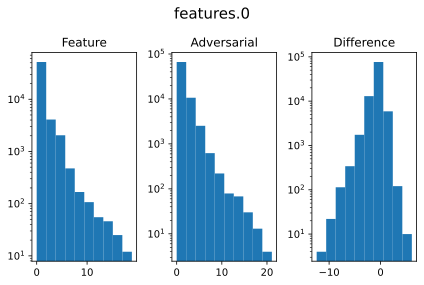

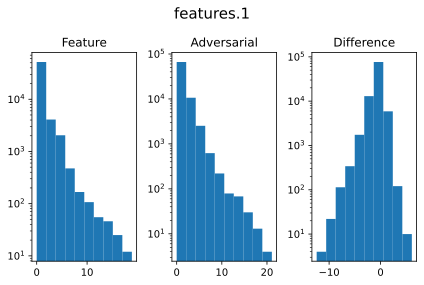

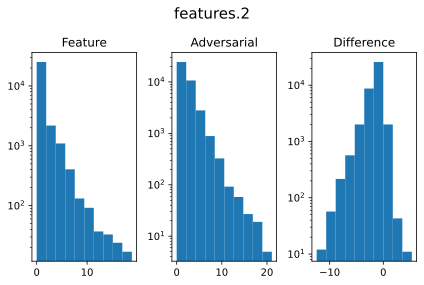

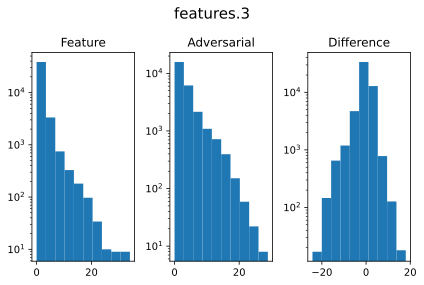

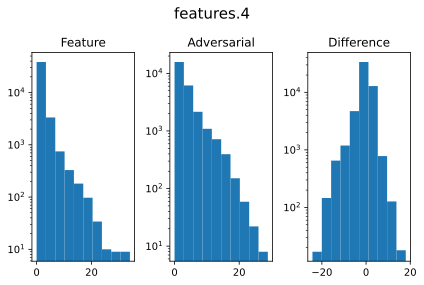

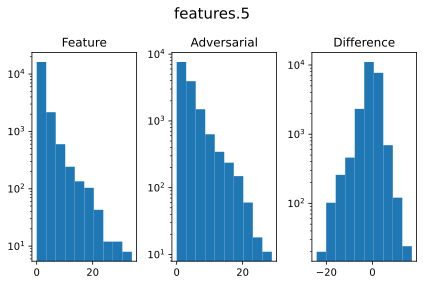

In [78]:
# Plot the activations of the 2nd through 7th layers of the model
_ = plot_all_features(1, 7)

The code below shows where I started to learn more about Captum, a library for doing attributions.

As you can see, I didn't get very far.

In [ ]:
# Notes
# The question of whether and adversarial example is "activating" several neurons or working on a few
# is a ticklish question; one way is to use conductance and oblations to determine which neurons have the strongest
# impact on the result.
# Start working on attributions
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
ig = IntegratedGradients(pretrained_model)
baseline = torch.zeros_like(test_img)
attributions, delta = ig.attribute(test_img, baseline, target=0, return_convergence_delta=True)